In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_excel('/content/NGAsub_MegaFlatfile_RotD50_050_R211022_public- Week5.xlsx')
df.shape

(71340, 227)

In [ ]:
df.rename(columns={
    'PGA_g': 'pga',
    'Earthquake_Magnitude': 'mag',
    'Rjb_km': 'rjb',
    'Hypocenter_Depth_km': 'hypd',
    'Vs30_Selected_for_Analysis_m_s': 'vs30',
    'Intra_Inter_Flag': 'intra_inter',
    'Sensor_Depth_m': 'sensor_depth',
    'Multiple_Event': 'multi_event',
    'Late_P_trigger_flag_1ptYes_0ptNo': 'late_flag',
    'Source_review_flag': 'src_flag',
    'Longest_Usable_Period_for_PSa_Ave_Component_sec': 'tgm',
    'NGAsubEQID': 'EqID',
    'Station_Name':'siteID'
}, inplace=True)

In [ ]:
df = df[(df['pga'] != -999) & (df['pga'] <= 10) & (df['mag'] >= 4)]

meta_cols = ['mag', 'rjb', 'hypd', 'vs30',"Ztor_km"]
for col in meta_cols:
    df = df[df[col] != -999]

df = df[df['intra_inter'].isin([0, 1, 5])]

is_interface = (df['intra_inter'] == 0) & (df['hypd'] < 40)
is_intraslab = (df['intra_inter'] == 1) & (df['hypd'] < 200)
df = df[is_interface | is_intraslab]

df = df[df['rjb'] <= 1000]

df = df[df['sensor_depth'] <= 2]

df = df[df['multi_event'] != 1]

df = df[df['late_flag'] != 1]

df = df[df['src_flag'].isin([0, 1, 2, 4])]

df = df[df['tgm'] >= 10]

event_counts = df['EqID'].value_counts()
valid_eids = event_counts[event_counts >= 3].index
df = df[df['EqID'].isin(valid_eids)]
df.shape

(14526, 227)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
import numpy as np
import pandas as pd


In [ ]:
input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']
target_cols = [
    "T0pt010S", "T0pt020S", "T0pt030S", "T0pt050S", "T0pt075S",
    "T0pt100S", "T0pt150S", "T0pt200S", "T0pt300S", "T0pt400S",
    "T0pt500S", "T0pt750S", "T1pt000S", "T1pt500S", "T2pt000S",
    "T2pt500S", "T3pt000S", "T3pt500S", "T4pt000S", "T5pt000S"
]

df['rjb'] = df['rjb'].replace(0, 0.01).replace([np.inf, -np.inf], np.nan)
df['vs30'] = df['vs30'].astype(float).replace(0, 0.01).replace([np.inf, -np.inf], np.nan)

# Log-transform rjb and vs30
df['logrjb'] = np.log10(df['rjb'])
df['logvs30'] = np.log10(df['vs30'])

# Drop any rows with NaN
df = df.dropna(subset=input_cols + target_cols)

# Extract inputs and targets
inputs = df[input_cols].values
targets = df[target_cols].values

# >>>>> Correct: Apply natural log to targets <<<<<
targets = np.log(targets)

# Normalize inputs and targets separately
scaler_input = StandardScaler()
scaler_target = StandardScaler()

inputs_scaled = scaler_input.fit_transform(inputs)
targets_scaled = scaler_target.fit_transform(targets)

# Save EqID and SiteID for residual calculations
EqIDs = df['EqID'].values
siteIDs = df['siteID'].values

# Train-validation-test split (randomized split)
X_train, X_temp, y_train, y_temp, EqID_train, EqID_temp, siteID_train, siteID_temp = train_test_split(
    inputs_scaled, targets_scaled, EqIDs, siteIDs, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test, EqID_val, EqID_test, siteID_val, siteID_test = train_test_split(
    X_temp, y_temp, EqID_temp, siteID_temp, test_size=0.5, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from statsmodels.regression.mixed_linear_model import MixedLM
import numpy as np
import pandas as pd

# Build the RF model once
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

max_iterations = 15
NoOfOutput = len(target_cols)
LH = np.zeros((max_iterations, NoOfOutput))
LHR = np.zeros((max_iterations, NoOfOutput))

best_model = model
best_iteration = 0
min_val_loss = float('inf')

for iteration in range(max_iterations):
    print(f"\n--- Iteration {iteration+1}/{max_iterations} ---")

    # Fit on training data
    model.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred_scaled = model.predict(X_val)
    val_loss = np.mean((y_val - y_val_pred_scaled) ** 2)  # MSE

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model = model
        best_iteration = iteration + 1

    # Predict on full dataset
    y_pred_scaled = model.predict(inputs_scaled)
    y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
    y_true_log = scaler_target.inverse_transform(targets_scaled)

    residuals = y_true_log - y_pred_log

    inter_event = np.zeros((len(np.unique(EqIDs)), NoOfOutput))
    intra_event = np.zeros((residuals.shape[0], NoOfOutput))
    site_event = np.zeros((len(np.unique(siteIDs)), NoOfOutput))

    for i in range(NoOfOutput):
        data_table = pd.DataFrame({
            'residual': residuals[:, i],
            'EqID': EqIDs,
            'siteID': siteIDs
        })

        model_mixed = MixedLM.from_formula("residual ~ 1", groups="EqID", re_formula="1", data=data_table)
        result = model_mixed.fit()

        group_effects = result.random_effects
        for j, eqid in enumerate(np.unique(EqIDs)):
            inter_event[j, i] = group_effects[eqid].iloc[0]

        for j in range(len(EqIDs)):
            intra_event[j, i] = residuals[j, i] - inter_event[np.where(np.unique(EqIDs) == EqIDs[j])[0][0], i]

    # Evaluate on training data
    y_train_pred = model.predict(X_train)
    LH[iteration, :] = np.mean((y_train - y_train_pred) ** 2, axis=0)

    if iteration > 0:
        LHR[iteration, :] = (LH[iteration, :] - LH[iteration-1, :]) * 100 / np.abs(LH[iteration-1, :])

    if np.max(np.abs(LHR[iteration, :])) < 10 and iteration > 1:
        print(f"Early stopping at iteration {iteration+1}")
        break


--- Iteration 1/15 ---

--- Iteration 2/15 ---

--- Iteration 3/15 ---
Early stopping at iteration 3


In [ ]:
from scipy.stats import pearsonr

# Assuming y_true_log and y_pred_log are your log-transformed true and predicted values
def calculate_correlation(y_true, y_pred):
    correlations = []
    for i in range(y_true.shape[1]):
        corr, _ = pearsonr(y_true[:, i], y_pred[:, i])
        correlations.append(corr)
    return correlations

def calculate_pp(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    sigma = np.std(y_true)
    PP = 1 / (mse / sigma)
    return PP

def calculate_slope(y_true, y_pred):
    Y_mean = np.mean(y_true, axis=0)
    y_mean = np.mean(y_pred, axis=0)
    numerator = np.sum((y_true - Y_mean) * (y_pred - y_mean), axis=0)
    denominator = np.sum((y_true - Y_mean)**2, axis=0)
    k = numerator / denominator
    return k

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred, multioutput='uniform_average')

def calculate_a(R_model, R_target):
    return np.abs(R_model - R_target)

# Calculate performance parameters
R = calculate_correlation(y_true_log, y_pred_log)
PP = calculate_pp(y_true_log, y_pred_log)
k = calculate_slope(y_true_log, y_pred_log)
R_squared = calculate_r2(y_true_log, y_pred_log)

# Target R² (assumed to be close to 1 for best performance)
R_target = 1
a = calculate_a(R_squared, R_target)

# Print results
print(f"Correlation Coefficients (R): {R}")
print(f"Performance Parameter (PP): {PP}")
print(f"Slope (k): {k}")
print(f"R²: {R_squared}")
print(f"a: {a}")

Correlation Coefficients (R): [np.float64(0.9566747971045375), np.float64(0.9563966072125792), np.float64(0.9556498420499154), np.float64(0.9523388875727192), np.float64(0.9472109560026154), np.float64(0.9444944062750082), np.float64(0.9460439275207029), np.float64(0.9482319768225995), np.float64(0.9534850287954861), np.float64(0.9561630065044877), np.float64(0.9568424714415228), np.float64(0.9546185361011268), np.float64(0.9522009562623858), np.float64(0.9486080818044705), np.float64(0.9481876100410591), np.float64(0.9495139883783476), np.float64(0.9509689631878425), np.float64(0.9525571112664217), np.float64(0.9545418081758428), np.float64(0.9587521210338029)]
Performance Parameter (PP): 5.143240420356709
Slope (k): [0.88539439 0.8848924  0.88359746 0.8764514  0.86582896 0.85980002
 0.86255313 0.86636586 0.87823539 0.8848589  0.88700129 0.88176713
 0.87593182 0.86724309 0.86505849 0.86767454 0.868819   0.87227933
 0.87595574 0.88393405]
R²: 0.9055175268187687
a: 0.09448247318123126


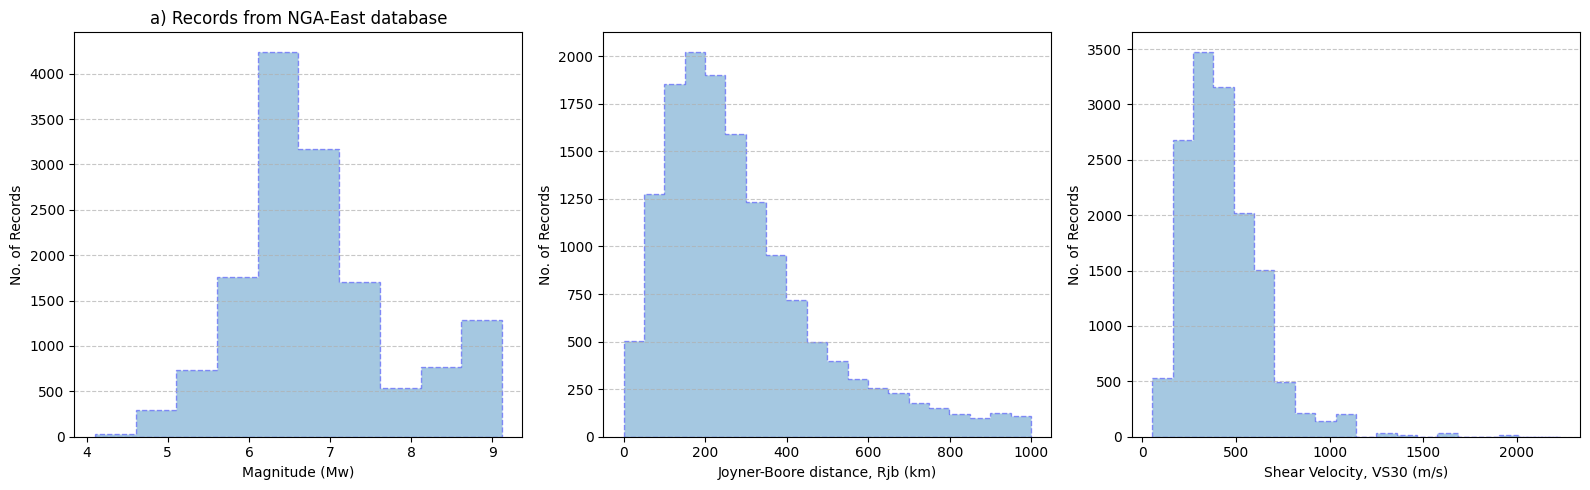

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Replace 'df_clean' with 'df' (or the actual name of your DataFrame)
axs[0].hist(df["mag"], bins=10, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[0].set_xlabel("Magnitude (Mw)")
axs[0].set_ylabel("No. of Records")
axs[0].set_title("a) Records from NGA-East database")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].hist(df["rjb"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[1].set_xlabel("Joyner-Boore distance, Rjb (km)")
axs[1].set_ylabel("No. of Records")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

axs[2].hist(df["vs30"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[2].set_xlabel("Shear Velocity, VS30 (m/s)")
axs[2].set_ylabel("No. of Records")
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

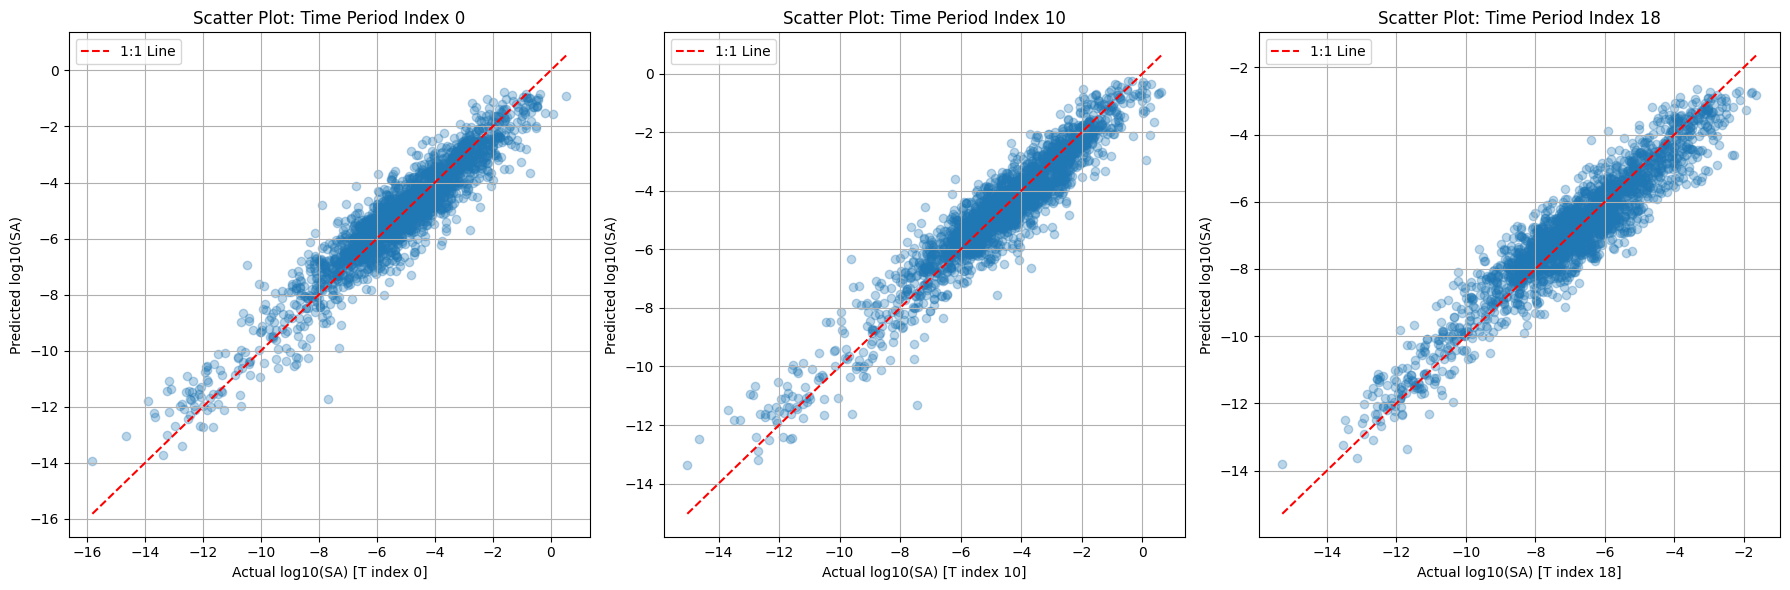

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spectral_indices = [0, 10, 18]

# Get original log-space values (no exp if already in log)
Y_test_log = scaler_target.inverse_transform(y_test)
Y_pred_scaled = best_model.predict(X_test)
Y_pred_log = scaler_target.inverse_transform(Y_pred_scaled)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, idx in enumerate(spectral_indices):
    ax = axs[i]
    ax.scatter(Y_test_log[:, idx], Y_pred_log[:, idx], alpha=0.3)
    ax.plot([Y_test_log[:, idx].min(), Y_test_log[:, idx].max()],
            [Y_test_log[:, idx].min(), Y_test_log[:, idx].max()], 'r--', label='1:1 Line')

    ax.set_xlabel(f'Actual log10(SA) [T index {idx}]')
    ax.set_ylabel('Predicted log10(SA)')
    ax.set_title(f'Scatter Plot: Time Period Index {idx}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

<ipython-input-80-9b1e561be3c7>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby('bin')['x'].mean()
<ipython-input-80-9b1e561be3c7>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['y'].mean()
<ipython-input-80-9b1e561be3c7>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stds = df.groupby('bin')['y'].std()
<ipython-input-80-9b1e561be3c7>:12: FutureWarning: T

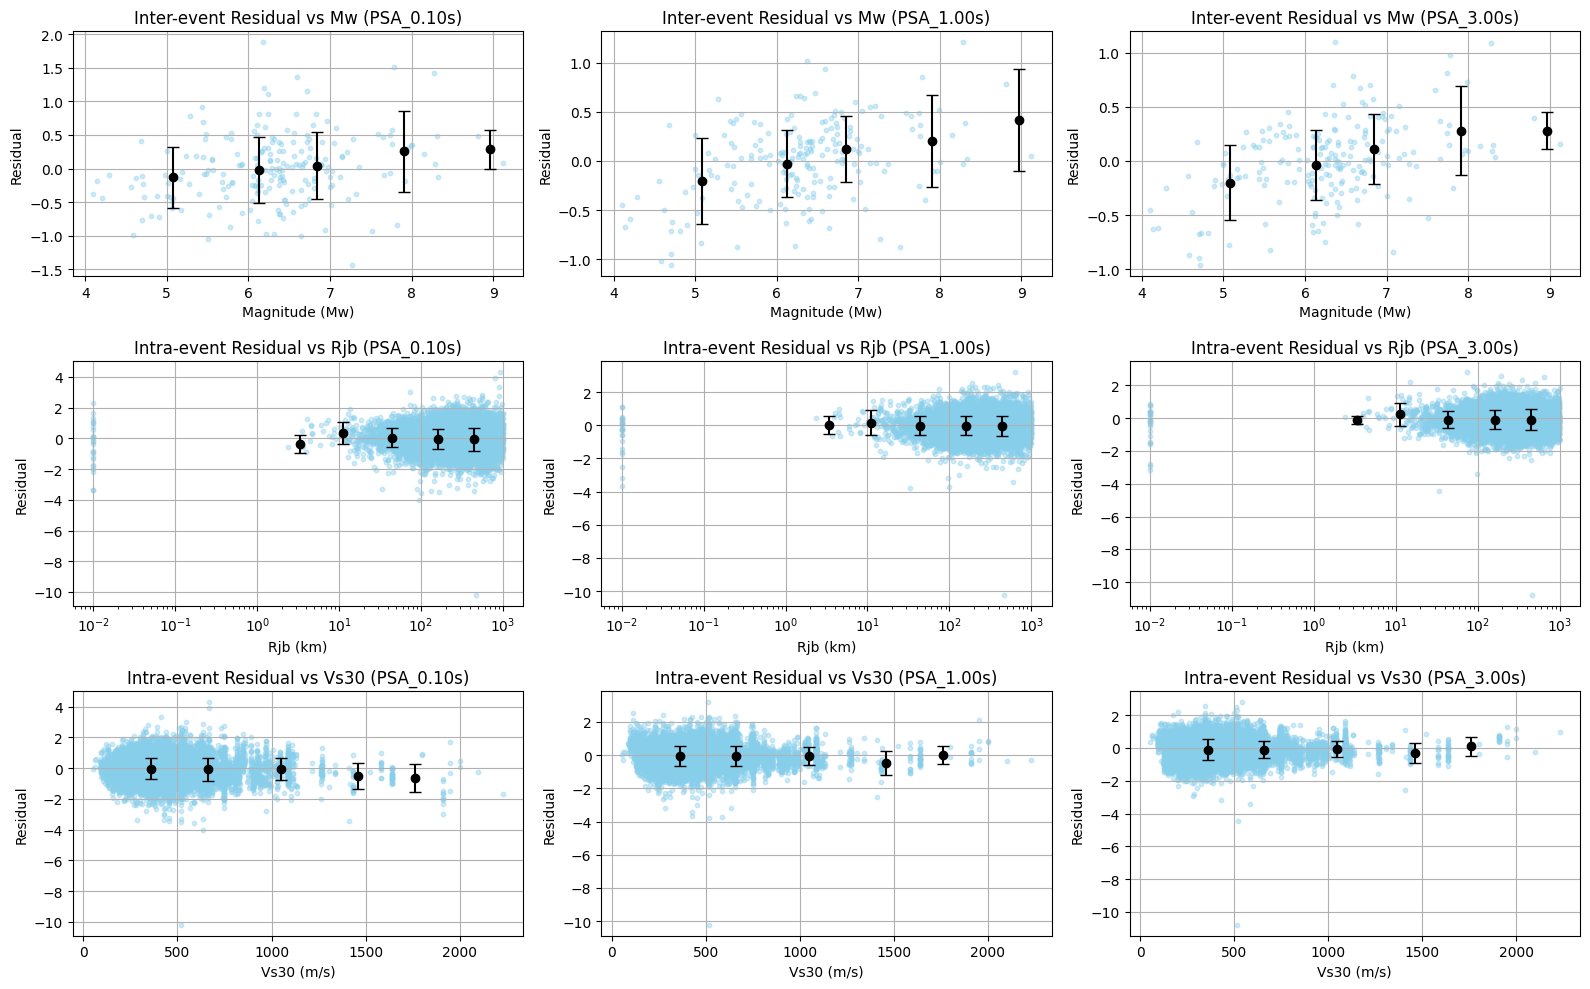

In [ ]:
time_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4,
                0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

selected_indices = [5, 12, 16]  # Modify based on your period selection
selected_labels = [f"PSA_{time_periods[i]:.2f}s" for i in selected_indices]

# Plotting function with binned mean/std
def plot_residual_binned(x, y, xlabel, title, log_x=False, bins=6, ax=None):
    df = pd.DataFrame({'x': x, 'y': y})
    df['bin'] = pd.cut(df['x'], bins=bins)

    bin_centers = df.groupby('bin')['x'].mean()
    bin_means = df.groupby('bin')['y'].mean()
    bin_stds = df.groupby('bin')['y'].std()

    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, s=10, color='skyblue')
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', capsize=4)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residual")
    ax.set_title(title)
    if log_x:
        ax.set_xscale("log")
    ax.grid(True)

# Plot setup
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

for col, i in enumerate(selected_indices):
    # Inter-event vs Mw
    eq_unique, eq_idx = np.unique(EqIDs, return_index=True)
    Mw_vals = df['mag'].values[eq_idx]  # assuming 'mag' is moment magnitude
    plot_residual_binned(
        Mw_vals,
        inter_event[:, i],
        xlabel="Magnitude (Mw)",
        title=f"Inter-event Residual vs Mw ({selected_labels[col]})",
        bins=np.linspace(4.5, 9.5, 6),
        ax=axs[0, col]
    )

    # Intra-event vs Rjb
    plot_residual_binned(
        df['rjb'].values,
        intra_event[:, i],
        xlabel="Rjb (km)",
        title=f"Intra-event Residual vs Rjb ({selected_labels[col]})",
        bins=np.logspace(0, 3, 6),
        log_x=True,
        ax=axs[1, col]
    )

    # Intra-event vs Vs30
    plot_residual_binned(
        df['vs30'].values,
        intra_event[:, i],
        xlabel="Vs30 (m/s)",
        title=f"Intra-event Residual vs Vs30 ({selected_labels[col]})",
        bins=np.linspace(180, 2000, 6),
        ax=axs[2, col]
    )

plt.tight_layout()
plt.show()

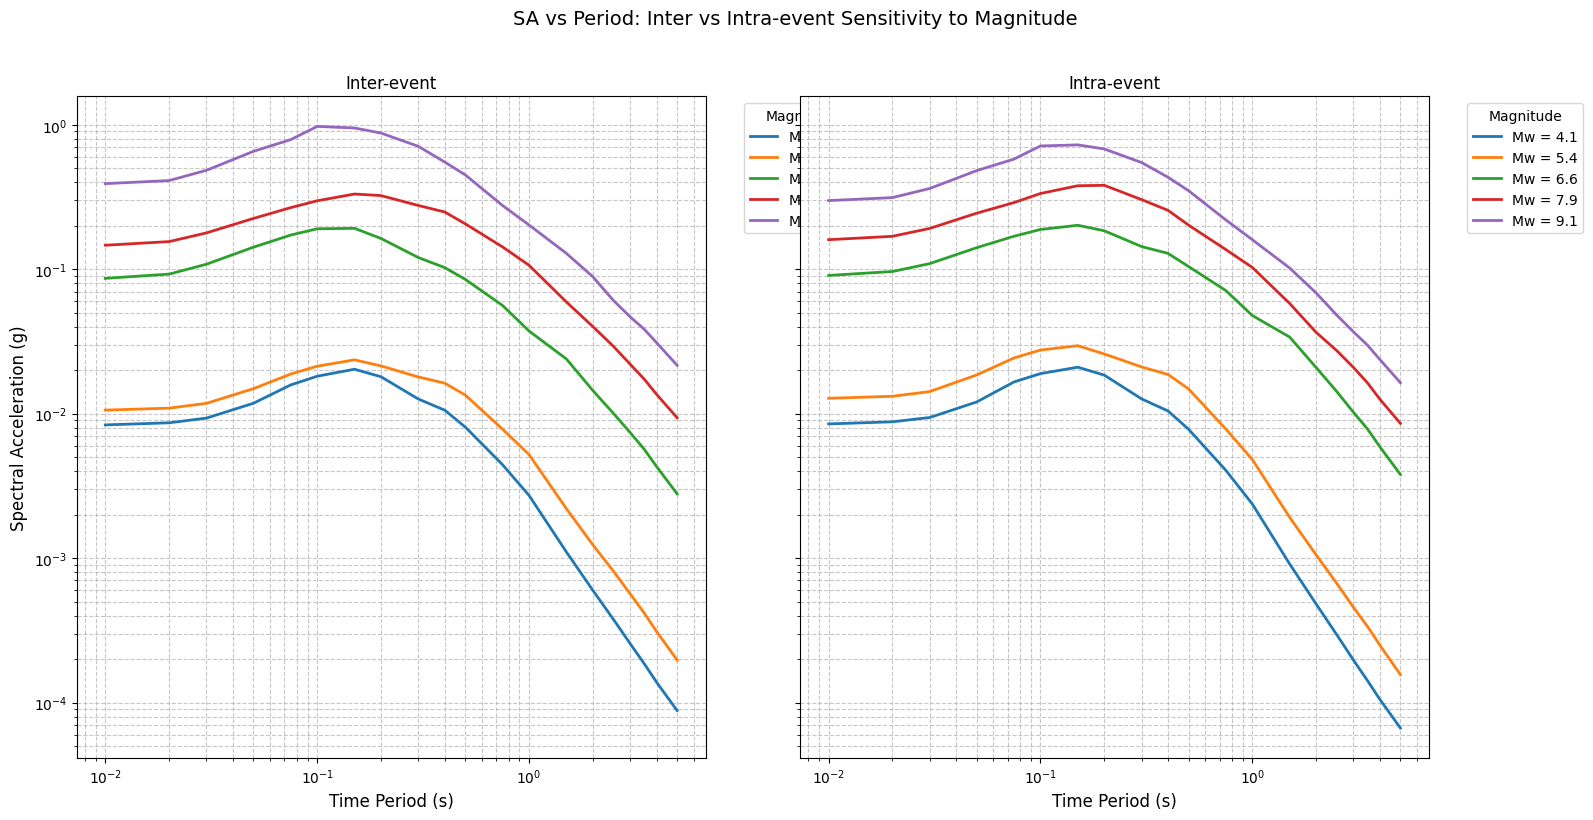

In [ ]:
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed values
fixed_rjb = 6.5
fixed_vs30 = 700.0
logrjb = np.log10(max(fixed_rjb, 0.01))
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Mw range from data
mw_range = np.linspace(df['mag'].min(), df['mag'].max(), 5)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)  # Increased figure size

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for mw in mw_range:
        X_input = np.array([[mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
        y_pred = np.exp(y_pred_log)

        label = f'Mw = {mw:.1f}'
        ax.semilogy(periods, y_pred.flatten(), label=label, linewidth=2)  # Using semilogy for log scale

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=12)
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which="both", linestyle='--', alpha=0.7)
    ax.set_xscale('log')  # Log scale for x-axis if periods vary widely

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)

    # Adjust legend position and size
    ax.legend(title="Magnitude", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Magnitude", fontsize=14, y=1.02)
plt.tight_layout()

# Add more vertical space between plots if needed
plt.subplots_adjust(wspace=0.15)

plt.show()

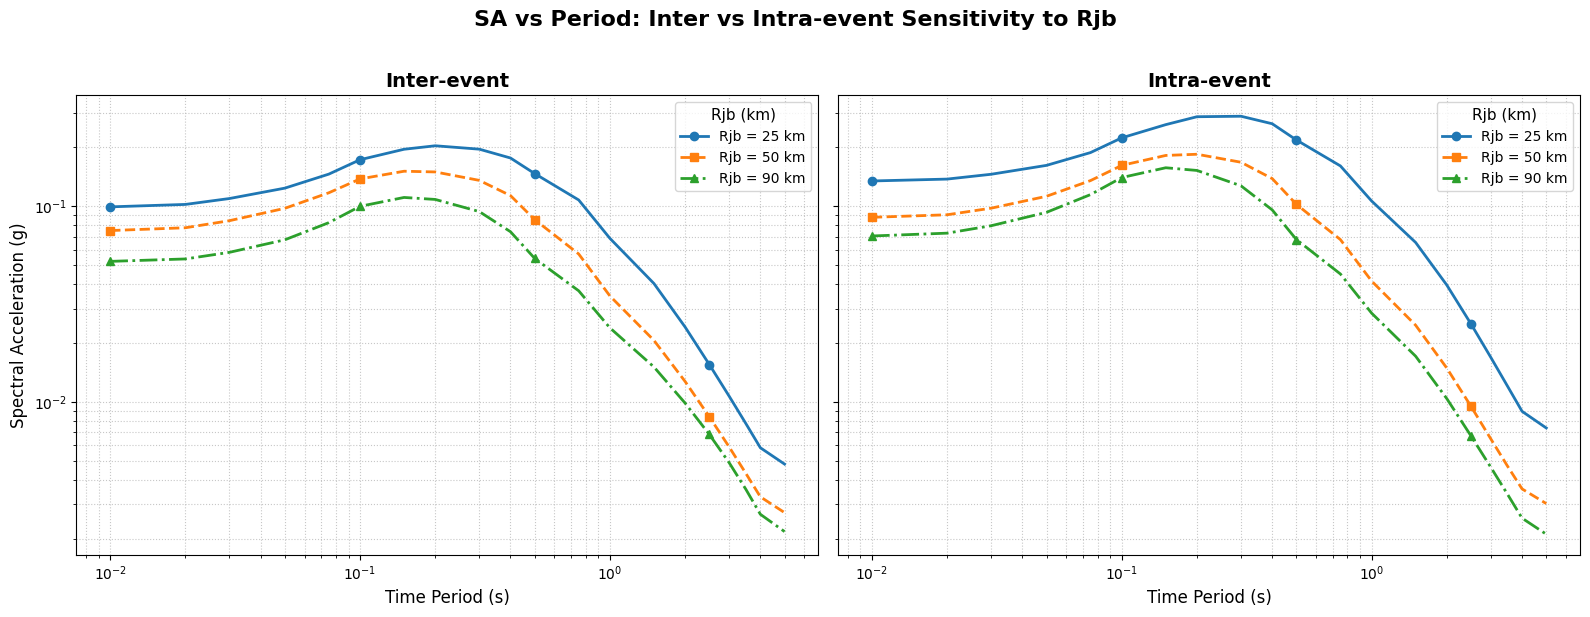

In [ ]:
from scipy.ndimage import gaussian_filter1d

fixed_mw = 6.5
fixed_vs30 = 300
logvs30 = np.log10(max(fixed_vs30, 0.01))
rjb_values = [25,50,90]

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for i, rjb in enumerate(rjb_values):
        logrjb = np.log10(max(rjb, 0.01))
        X_input = np.array([[fixed_mw, rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)

        # Apply Gaussian smoothing
        y_pred_log_smooth = gaussian_filter1d(y_pred_log.flatten(), sigma=1.2)
        y_pred = np.exp(y_pred_log_smooth)

        label = f'Rjb = {rjb} km'
        ax.plot(periods, y_pred,
                linestyle=line_styles[i % len(line_styles)],
                marker=markers[i % len(markers)],
                markevery=5,
                linewidth=2,
                label=label)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=14, weight='bold')
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)
    ax.legend(title="Rjb (km)", fontsize=10, title_fontsize=11)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Rjb",
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

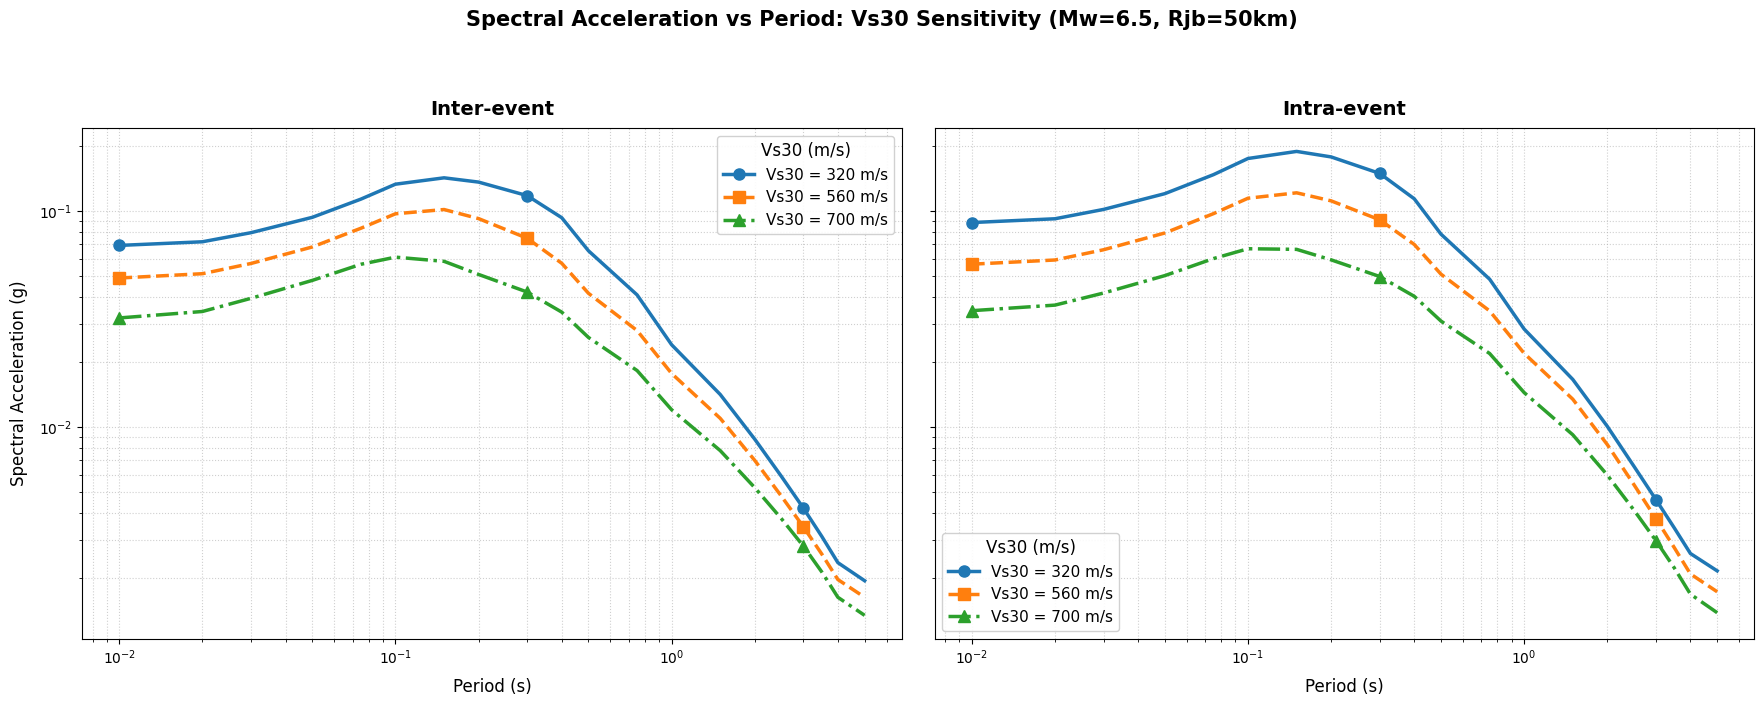

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

fixed_mw = 6.5
fixed_rjb = 65
logrjb = np.log10(max(fixed_rjb, 0.01))

vs30_values = [320,560, 700]

styles = {
    320: {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o', 'linewidth': 2.5},
    560: {'color': '#ff7f0e', 'linestyle': '--', 'marker': 's', 'linewidth': 2.5},
    700: {'color': '#2ca02c', 'linestyle': '-.', 'marker': '^', 'linewidth': 2.5},
}

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]

    for vs30 in vs30_values:
        logvs30 = np.log10(max(vs30, 0.01))
        X_input = np.array([[fixed_mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)

        # Smooth the log(SA) values
        y_pred_log_smooth = gaussian_filter1d(y_pred_log.flatten(), sigma=1.2)
        y_pred = np.exp(y_pred_log_smooth)

        ax.plot(periods, y_pred,
                label=f'Vs30 = {vs30} m/s',
                **styles[vs30],
                markersize=8,
                markevery=8)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event",
                 fontsize=14, pad=10, weight='bold')
    ax.set_xlabel("Period (s)", fontsize=12, labelpad=8)
    ax.grid(True, which='both', linestyle=':', alpha=0.6)

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12, labelpad=8)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(title="Vs30 (m/s)",
              fontsize=11,
              title_fontsize=12,
              framealpha=0.9,
              loc='upper right' if intra_inter_val == 0 else 'lower left')

plt.suptitle("Spectral Acceleration vs Period: Vs30 Sensitivity (Mw=6.5, Rjb=50km)",
             fontsize=15, weight='bold', y=1.02)

plt.tight_layout(pad=2.0)
plt.show()

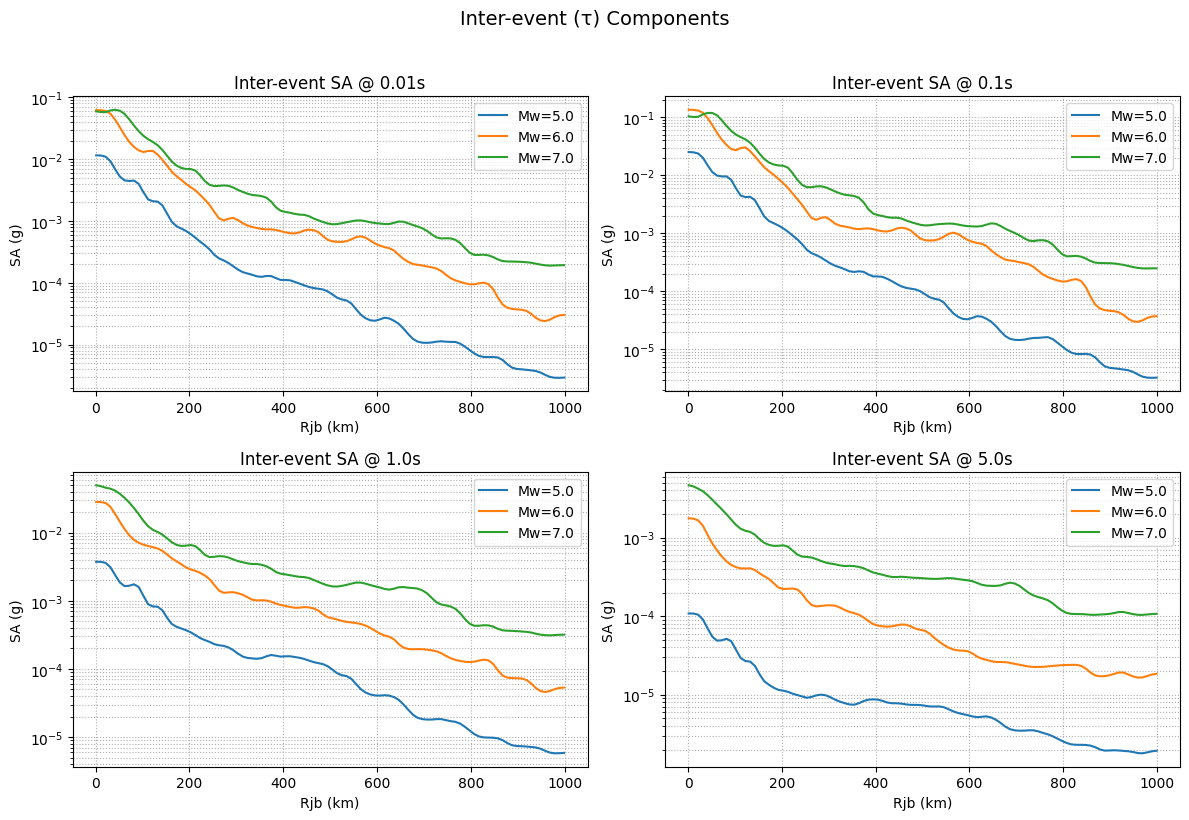

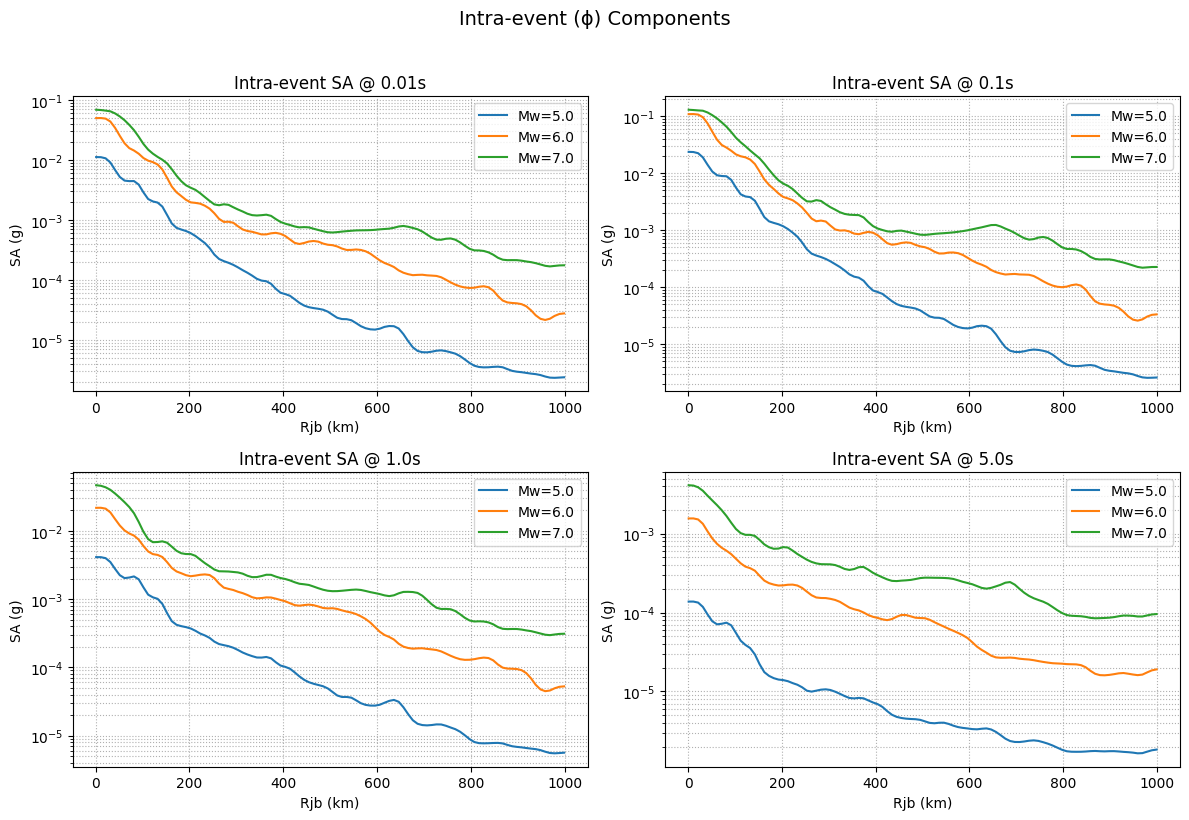

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Setup
selected_period_indices = [0, 5, 12, 19]
selected_periods = [float(target_cols[i][1:].replace('pt', '.').replace('S', '')) for i in selected_period_indices]

rjb_range = np.linspace(max(df['rjb'].min(), 1), df['rjb'].max(), 100)  # Avoid log(0)
mw_values = [5.0, 6.0, 7.0]
fixed_vs30 = 760
logvs30 = np.log10(fixed_vs30)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Consistent color mapping

# === Figure 1: Inter-event (τ) ===
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw_idx, mw in enumerate(mw_values):
        sa_values_log = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 1]])  # 1 for inter-event
            X_scaled = scaler_input.transform(X_input)
            y_pred_scaled = best_model.predict(X_scaled)
            y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
            sa_values_log.append(y_pred_log[0, iT])

        # Smooth in log-space
        sa_log_smooth = gaussian_filter1d(sa_values_log, sigma=1.0)
        sa_values = np.exp(sa_log_smooth)

        plt.semilogy(rjb_range, sa_values, label=f'Mw={mw}', color=colors[mw_idx])

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Inter-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls=":")
    plt.legend()

plt.suptitle("Inter-event (τ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# === Figure 2: Intra-event (ϕ) ===
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw_idx, mw in enumerate(mw_values):
        sa_values_log = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 0]])  # 0 for intra-event
            X_scaled = scaler_input.transform(X_input)
            y_pred_scaled = best_model.predict(X_scaled)
            y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
            sa_values_log.append(y_pred_log[0, iT])

        # Smooth in log-space
        sa_log_smooth = gaussian_filter1d(sa_values_log, sigma=1.0)
        sa_values = np.exp(sa_log_smooth)

        plt.semilogy(rjb_range, sa_values, label=f'Mw={mw}', color=colors[mw_idx])

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Intra-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls=":")
    plt.legend()

plt.suptitle("Intra-event (ϕ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

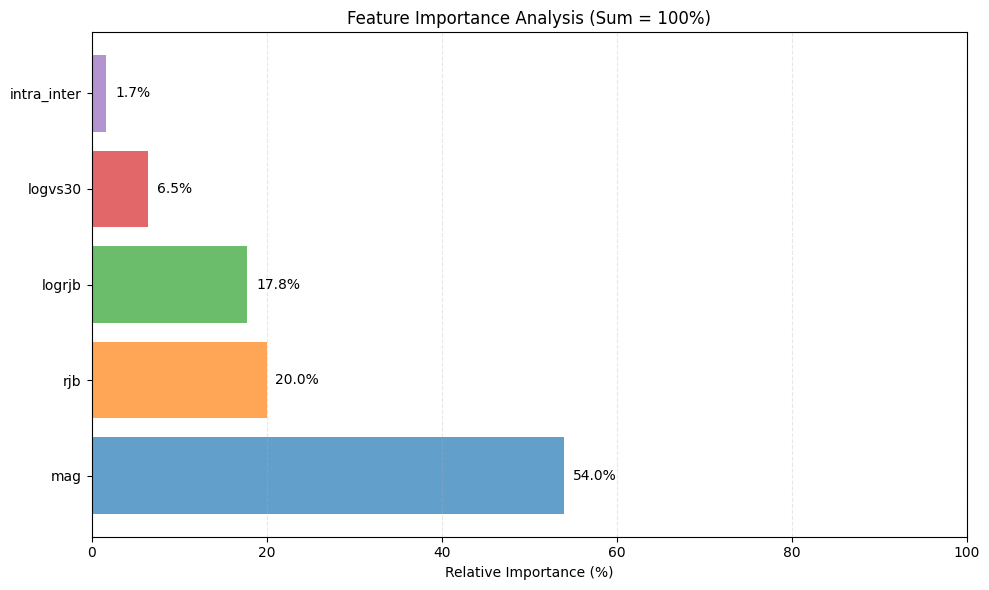

Sum of importance values: 100.0%


In [ ]:
from sklearn.inspection import permutation_importance

def scoring_fn(estimator, X, y):
    y_pred = estimator.predict(X)
    mse_per_period = np.mean((y - y_pred) ** 2, axis=0)
    return -np.mean(mse_per_period)

# Compute permutation importance
result = permutation_importance(
    best_model,
    X_val,
    y_val,
    scoring=scoring_fn,
    n_repeats=10,
    random_state=42
)

# Calculate raw and normalized importances
feature_importance = result.importances_mean
total_importance = np.sum(np.abs(feature_importance))
normalized_importance = np.round((feature_importance / total_importance) * 100, 1)

# Adjust last value for exact 100%
normalized_importance[-1] += 100 - np.round(np.sum(normalized_importance),1)

# Sort features
sorted_idx = np.argsort(normalized_importance)[::-1]
sorted_features = np.array(input_cols)[sorted_idx]
sorted_importance = normalized_importance[sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = plt.barh(range(len(sorted_features)), sorted_importance, color=colors, alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}%", va='center', ha='left')

plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlim(0, 100)
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importance Analysis (Sum = 100%)")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print exact total
print(f"Sum of importance values: {np.round(np.sum(normalized_importance), 4)}%")

In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP TreeExplainer for the trained RandomForest model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_val)  # List of arrays: one (n_samples, n_features) per output

# Loop through each target (i.e., each spectral acceleration period)
for i, shap_vals_for_output in enumerate(shap_values):
    print(f"Plotting SHAP summary for output target {i}...")

    # Create summary plot
    shap.summary_plot(
        shap_vals_for_output,  # shape: (n_samples, n_features)
        X_val,                 # Corresponding input data
        feature_names=input_cols,
        show=False
    )

    # Add custom title
    plt.title(f"SHAP Summary Plot for Target Variable {i}", fontsize=14)
    plt.tight_layout()
    plt.show()


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>